<a href="https://colab.research.google.com/github/codeavenger456/MNIST_Max-digits/blob/main/Copy_of_MNIST_Max_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install kaggle

## Authenticating with Kaggle using kaggle.json

Navigate to https://www.kaggle.com. Then go to the [Account tab of your user profile](https://www.kaggle.com/me/account) and select Create API Token. This will trigger the download of kaggle.json, a file containing your API credentials.

Then run the cell below to upload kaggle.json to your Colab runtime.

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 70 bytes


In [3]:
! kaggle competitions download -c mais-202-fall-2020-kaggle-competition

 93% 183M/196M [00:02<00:00, 103MB/s] 
100% 196M/196M [00:02<00:00, 72.4MB/s]
  0% 0.00/341k [00:00<?, ?B/s]
100% 341k/341k [00:00<00:00, 112MB/s]
 98% 769M/784M [00:06<00:00, 145MB/s]
100% 784M/784M [00:06<00:00, 120MB/s]


In [4]:
! unzip train_x.npy.zip

Archive:  train_x.npy.zip
  inflating: train_x.npy             


In [5]:
import numpy as np
train_images = np.load("train_x.npy")

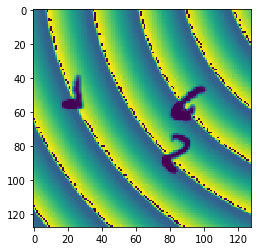

In [6]:
import matplotlib.pyplot as plt

def show_image(arr):
    two_d = (np.reshape(arr, (128, 128)) * 255).astype(np.uint8)
    plt.imshow(two_d, interpolation='nearest')
    plt.show()

show_image(train_images[0]) # 0 is the index of the training image you want to display

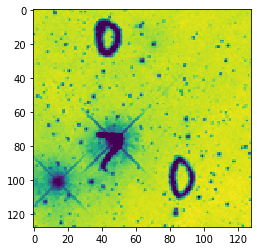

In [7]:
show_image(train_images[1])

# Libraries and dependencies

Add all your imports here

In [8]:
import cv2
import numpy as np
from keras.datasets import mnist
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv2D
from keras.models import Sequential
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import copy

## Preprocessing

Assuming each image contains three digits, below is the code that extracts all three digits from the image.

Call num_extraction on an entry of the training_images will extract the digits and append them into preprocessed_digits list. 

The process will alter the original input picture, so if you encounter bugs it could be related to this. Since we are not using the original training_images I will not worry about this. I have attached an example below so you can see what the extracted image looks like. It is 28x28 pixels just for reference.

In [9]:
preprocessed_digits = []

In [10]:
def num_extraction(input_image):
  image = input_image

  ## comment this out at the end
  print("\n\n\n----------------Original Image--------------------")
  show_image(image)
  ## comment this out at the end

  ret, thresh = cv2.threshold(image.copy(), 180, 255, cv2.THRESH_BINARY_INV)
  contours, _= cv2.findContours(thresh.copy().astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  list_size = [cv2.contourArea(c) for c in contours]
  list_size.sort(reverse = True)
  list_size = list_size[1:4]
  for c in contours:
      area = cv2.contourArea(c)
      if area in list_size:
        x,y,w,h = cv2.boundingRect(c)
        # Creating a rectangle around the digit in the original image (for displaying the digits fetched via contours)
        cv2.rectangle(image, (x,y), (x+w, y+h), color=(255, 255, 255), thickness=1)
        
        # Cropping out the digit from the image corresponding to the current contours in the for loop
        digit = thresh[y:y+h, x:x+w]
        
        # Resizing that digit to (18, 18)
        resized_digit = cv2.resize(digit, (18,18))
        
        # Padding the digit with 5 pixels of black color (zeros) in each side to finally produce the image of (28, 28)
        padded_digit = np.pad(resized_digit, ((5,5),(5,5)), "constant", constant_values=255)
        
        # Adding the preprocessed digit to the list of preprocessed digits
        preprocessed_digits.append(padded_digit)

  ## comment this out at the end
  print("\n\n\n----------------Contoured Image--------------------")
  plt.imshow(image, cmap="gray")
  plt.show()
  ## comment this out at the end


  # inp = np.array(preprocessed_digits)




----------------Original Image--------------------


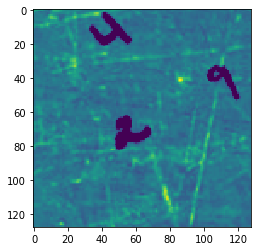




----------------Contoured Image--------------------


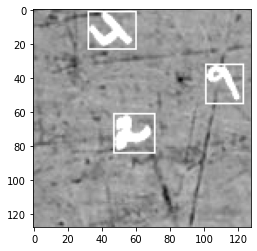

In [11]:
num_extraction(train_images[200])

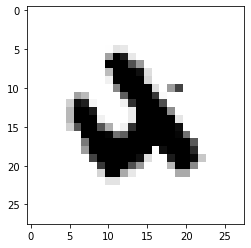

In [59]:
plt.imshow(preprocessed_digits[2], interpolation='nearest', cmap='gray')

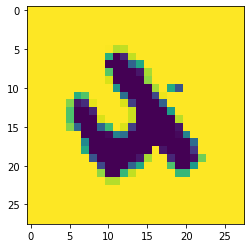

In [66]:
maybe = copy.deepcopy(preprocessed_digits[2])
maybe = maybe.astype(np.float32);
maybe /= 255.0
plt.imshow(maybe)

Building MNIST classifier

In [101]:
import keras
from keras.datasets import mnist
from keras.layers import BatchNormalization, Activation, MaxPooling2D, Dropout

Getting dataset

In [102]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Reshaping image

In [103]:
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

Normalization

In [104]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

In [105]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

Constructing the Model


In [106]:
model = Sequential([
# Layer 1
Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', input_shape = (28,28,1), kernel_regularizer=keras.regularizers.l2(0.0005)),
# Layer 2
Conv2D(filters = 32, kernel_size = 5, strides = 1, use_bias=False),
# Layer 3
keras.layers.BatchNormalization(),
# — — — — — — — — — — — — — — — — #
keras.layers.Activation('relu'),
MaxPooling2D(pool_size = 2, strides = 2),
Dropout(0.25),
# — — — — — — — — — — — — — — — — #
# Layer 3
Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', kernel_regularizer=keras.regularizers.l2(0.0005)),
# Layer 4
Conv2D(filters = 64, kernel_size = 3, strides = 1, use_bias=False),
# Layer 5
BatchNormalization(),
# — — — — — — — — — — — — — — — — #
Activation('relu'),
MaxPooling2D(pool_size = 2, strides = 2),
Dropout(0.25),
Flatten(),
# — — — — — — — — — — — — — — — — #
# Layer 6
Dense(units = 256, use_bias=False),
# Layer 7
BatchNormalization(),
# — — — — — — — — — — — — — — — — #
Activation('relu'),
# — — — — — — — — — — — — — — — — #
# Layer 8
Dense(units = 128, use_bias=False),
# Layer 9
BatchNormalization(),
# — — — — — — — — — — — — — — — — #
Activation('relu'),
# — — — — — — — — — — — — — — — — #
# Layer 10
Dense(units = 84, use_bias=False),
# Layer 11
BatchNormalization(),
# — — — — — — — — — — — — — — — — #
Activation('relu'),
Dropout(0.25),
# — — — — — — — — — — — — — — — — #
# Output
Dense(units = 10, activation = 'softmax')
])
model.summary()
#Credits to https://towardsdatascience.com/going-beyond-99-mnist-handwritten-digits-recognition-cfff96337392

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 20, 20, 32)        25600     
_________________________________________________________________
batch_normalization_29 (Batc (None, 20, 20, 32)        128       
_________________________________________________________________
activation_28 (Activation)   (None, 20, 20, 32)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 8, 8, 64)         

In [107]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=64, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
938/938 [==============================] - 198s 211ms/step - loss: 0.2305 - accuracy: 0.9398 - val_loss: 0.1172 - val_accuracy: 0.9717
Epoch 2/30
938/938 [==============================] - 196s 209ms/step - loss: 0.0948 - accuracy: 0.9777 - val_loss: 0.0503 - val_accuracy: 0.9895
Epoch 3/30
938/938 [==============================] - 195s 208ms/step - loss: 0.0735 - accuracy: 0.9827 - val_loss: 0.0448 - val_accuracy: 0.9901
Epoch 4/30
938/938 [==============================] - 195s 208ms/step - loss: 0.0602 - accuracy: 0.9855 - val_loss: 0.0380 - val_accuracy: 0.9917
Epoch 5/30
938/938 [==============================] - 196s 209ms/step - loss: 0.0577 - accuracy: 0.9863 - val_loss: 0.0405 - val_accuracy: 0.9908
Epoch 6/30
938/938 [==============================] - 199s 212ms/step - loss: 0.0521 - accuracy: 0.9878 - val_loss: 0.0336 - val_accuracy: 0.9927
Epoch 7/30
938/938 [==============================] - 195s 208ms/step - loss: 0.0486 - accuracy: 0.9884 - val_loss: 0.0327 -

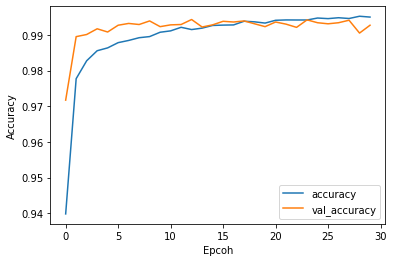

In [109]:
plt.plot(model.history.history["accuracy"], label="accuracy")
plt.plot(model.history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epcoh")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.show()

Save model

In [110]:
model.save('MNIST_classifier.h5')

Testing on train_X